# Feature Generating and Engineering
This notebook is for generating the features put into the model.

In [1]:
# Packages Load
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
import time

In [2]:
# Read Files
events = pd.read_pickle('../../data/events.pkl')
# attr = pd.read_pickle('data/attr.pkl')
session = pd.read_pickle('../../data/session.pkl')

In [3]:
submission = pd.read_csv('../../data/submission.csv')

In [4]:
events.head()

,session_id,event,event_timestamp,event_value,user_id_hash
0,5558845121177764917,45,1542215397132,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,5558845121177764917,45,1542215484895,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,7689508378645584666,.m5100869650219008,1541124410372,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,2201961907282901522,4,1543713091129,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,2201961907282901522,6,1543713093116,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...


Since our predictions are based on users, we need to create features on user base.

In [5]:
session.head()

,session_id,start_timestamp,timezone,timezone_offset,previous_sessions_duration,user_created_timestamp,is_user_first_session,country,region,city,latitude,longitude,locale,os_name,session_index,device_id,user_id_hash
0,5558845121177764917,1542215364580,Asia/Manila,28800000.0,25837591,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,30,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,18781111175537580,1539215568666,Asia/Manila,28800000.0,11343848,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,10,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,1477540082628742048,1540120743010,Asia/Manila,28800000.0,13499724,1538874289458,False,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,13,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,8184875317380844086,1542671625528,Asia/Manila,28800000.0,32788010,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,41,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,4706180700083856343,1538997913013,Asia/Manila,28800000.0,5872534,1538874289458,False,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,4,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [6]:
print(datetime.utcfromtimestamp(session.start_timestamp.min()/1000).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.utcfromtimestamp(session.start_timestamp.max()/1000).strftime('%Y-%m-%d %H:%M:%S'))

2018-10-01 07:00:04
2018-12-14 23:59:59


We will create labels during period Dec 1st and Dec 14th, and use features from Oct 1st to Nov 30th to train the model.

In [7]:
# Get the time stamp to split data.
print(datetime(2018,11,30,23,59,59).timestamp()*1000)
print(datetime(2018,12,7,23,59,59).timestamp()*1000)


1543622399000.0
1544227199000.0


In [8]:
# Split the data specifically for df feature generation
events_training = events[events.event_timestamp<=1543622399000]
session_training = session[session.start_timestamp<=1543622399000]

## Training Labels

In [9]:
# Label1 7-day purchase
purchase_user_7 = set(events[(events.event=='8') & (events.event_timestamp>1543622399000) & (events.event_timestamp<=1544227199000)].user_id_hash)
# Label2 14-day purchase
purchase_user_14 = set(events[(events.event=='8') & (events.event_timestamp>1543622399000)].user_id_hash)

In [10]:
len(purchase_user_7)

4729

In [11]:
len(purchase_user_14)

6126

#### Create Data Frame for df

In [12]:
training = pd.DataFrame(data = list(set(events.user_id_hash)&set(session.user_id_hash)), 
                        columns = ['user_id_hash'])

#### Create Labels

In [13]:
def label_create(df, label_1='user_purchase_binary_7_days', label_2='user_purchase_binary_14_days'):
    df[label_1] = df['user_id_hash'].apply(lambda x: x in purchase_user_7)
    df[label_2] = df['user_id_hash'].apply(lambda x: x in purchase_user_14)
    return df

In [14]:
training  = label_create(training)

In [15]:
training.shape

(619423, 3)

In [16]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False


## Training features
We will create user-based features one by one.

#### Feature One
How many events does this user has before?

In [17]:
count = events_training.loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'event_count'})
training = training.join(count.set_index('user_id_hash'), on = 'user_id_hash')

In [18]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32


#### Feature Two
How many times does this user purchased before?

In [19]:
count = events_training[events_training.event=='8'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
count().reset_index().rename(columns={'event':'purchase_count'})
training = training.join(count.set_index('user_id_hash'), on = 'user_id_hash')

In [20]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0


#### Feature Three
How many session does this users have in total?

In [21]:
count = session_training.loc[:, ['user_id_hash', 'session_id']].groupby('user_id_hash').\
count().reset_index().rename(columns={'session_id':'session_count'})
training = training.join(count.set_index('user_id_hash'), on = 'user_id_hash')

In [22]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1


#### Feature Four
Which country does this user from?

In [23]:
country = session_training.loc[:, ['user_id_hash', 'country']].groupby('user_id_hash').\
first().reset_index()
training = training.join(country.set_index('user_id_hash'), on = 'user_id_hash')

In [24]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1,US
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5,US
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6,MU
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1,US
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1,GB


#### Feature Five
Which OS does this user use?

In [25]:
os = session_training.loc[:, ['user_id_hash', 'os_name']].groupby('user_id_hash').\
first().reset_index()
training = training.join(os.set_index('user_id_hash'), on = 'user_id_hash')

In [26]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1,US,iOS
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5,US,Android OS
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6,MU,Android OS
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1,US,Android OS
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1,GB,iOS


#### Feature Six
How long the user spend on each session, on average.

In [27]:
duration = session_training.loc[:, ['user_id_hash', 'previous_sessions_duration']].groupby('user_id_hash').\
mean().reset_index().rename(columns={'previous_sessions_duration':'mean_sessions_duration'})
training = training.join(duration.set_index('user_id_hash'), on = 'user_id_hash')

In [28]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1,US,iOS,0.000000e+00
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5,US,Android OS,1.793310e+06
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6,MU,Android OS,1.745274e+06
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1,US,Android OS,0.000000e+00
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1,GB,iOS,0.000000e+00


#### Feature Seven
How much the user spent on the app before?

In [29]:
spend = events_training[events_training.event=='8'].loc[:, ['user_id_hash', 'event_value']].groupby('user_id_hash').\
sum().reset_index().rename(columns={'event_value':'spend'})
training = training.join(spend.set_index('user_id_hash'), on = 'user_id_hash')

In [30]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1,US,iOS,0.000000e+00,0.0
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5,US,Android OS,1.793310e+06,0.0
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6,MU,Android OS,1.745274e+06,0.0
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1,US,Android OS,0.000000e+00,0.0
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1,GB,iOS,0.000000e+00,0.0


#### Feature Eight
How long since the last time this user has an event?

In [31]:
event_gap = events_training.loc[:, ['user_id_hash', 'event_timestamp']].groupby('user_id_hash').\
max().reset_index().rename(columns={'event_timestamp':'event_gap'})
event_gap['event_gap'] = 1543622399000 - event_gap['event_gap'] 
training = training.join(event_gap.set_index('user_id_hash'), on = 'user_id_hash')

In [32]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1,US,iOS,0.000000e+00,0.0,1.016423e+09
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5,US,Android OS,1.793310e+06,0.0,1.574276e+09
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6,MU,Android OS,1.745274e+06,0.0,3.092714e+09
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1,US,Android OS,0.000000e+00,0.0,4.519232e+09
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1,GB,iOS,0.000000e+00,0.0,3.404691e+09


#### Feature Nine
How long since the last time this user has a session?

In [33]:
session_gap = session_training.loc[:, ['user_id_hash', 'start_timestamp']].groupby('user_id_hash').\
max().reset_index().rename(columns={'start_timestamp':'session_gap'})
session_gap['session_gap'] = 1543622399000 - session_gap['session_gap'] 
training = training.join(session_gap.set_index('user_id_hash'), on = 'user_id_hash')

In [34]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap,session_gap
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1,US,iOS,0.000000e+00,0.0,1.016423e+09,1.735038e+09
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5,US,Android OS,1.793310e+06,0.0,1.574276e+09,1.549573e+09
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6,MU,Android OS,1.745274e+06,0.0,3.092714e+09,3.215825e+09
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1,US,Android OS,0.000000e+00,0.0,4.519232e+09,4.519232e+09
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1,GB,iOS,0.000000e+00,0.0,3.404691e+09,3.405645e+09


#### Feature Ten
How long since this user started using this app?

In [35]:
life_time = session_training.loc[:, ['user_id_hash', 'user_created_timestamp']].groupby('user_id_hash').\
max().reset_index().rename(columns={'user_created_timestamp':'life_time'})
life_time['life_time'] = 1543622399000 - life_time['life_time'] 
training = training.join(life_time.set_index('user_id_hash'), on = 'user_id_hash')

In [36]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap,session_gap,life_time
0,43b7f548f3d8d032dc0d73526918e480b785babe5442df...,False,False,22,0,1,US,iOS,0.000000e+00,0.0,1.016423e+09,1.735038e+09,1.735038e+09
1,054b486e811158a22ed02e2736b31ae38c84000c42cb98...,False,False,59,0,5,US,Android OS,1.793310e+06,0.0,1.574276e+09,1.549573e+09,3.555362e+09
2,136f80bbc16a75f345b4dff7b59a33896c615faedcc673...,False,False,169,0,6,MU,Android OS,1.745274e+06,0.0,3.092714e+09,3.215825e+09,3.386241e+09
3,3a6b376f042d56f8217e26f8b1a85ce14c8d162d6aa5f4...,False,False,5,0,1,US,Android OS,0.000000e+00,0.0,4.519232e+09,4.519232e+09,4.519259e+09
4,9564a40587edf45ae577178334413a9b017167a0fa8542...,False,False,32,0,1,GB,iOS,0.000000e+00,0.0,3.404691e+09,3.405645e+09,3.405645e+09


## Feature Engineering

### Numeric Feature Scaling
The dataset has a lot of outliers, we try to normalize each feature, firstly we tried winsorization to shrink the data range, then we use some Log-transformation to deal with the right skew problems.

In [37]:
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

(array([6.14565e+05, 3.96900e+03, 6.74000e+02, 1.52000e+02, 3.80000e+01,
        1.00000e+01, 6.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([    0. ,  2318.6,  4637.2,  6955.8,  9274.4, 11593. , 13911.6,
        16230.2, 18548.8, 20867.4, 23186. ]),
 <a list of 10 Patch objects>)

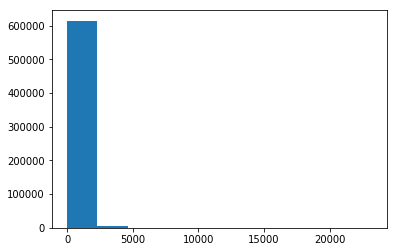

In [38]:
plt.hist(training.event_count)

(array([409270.,  83824.,  34815.,  18620.,  13261.,   9384.,   6589.,
          5082.,   4064.,  34514.]),
 array([  0. ,  71.7, 143.4, 215.1, 286.8, 358.5, 430.2, 501.9, 573.6,
        645.3, 717. ]),
 <a list of 10 Patch objects>)

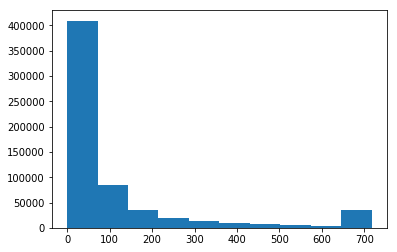

In [46]:
plt.hist(winsorize(training.event_count, limits=[0,0.05]))

/home/wtq920828/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(array([   334.,  35039.,  64329.,  51198., 104999., 105086.,  93102.,
         65097.,  42566.,  57673.]),
 array([0.        , 0.65750758, 1.31501517, 1.97252275, 2.63003034,
        3.28753792, 3.9450455 , 4.60255309, 5.26006067, 5.91756826,
        6.57507584]),
 <a list of 10 Patch objects>)

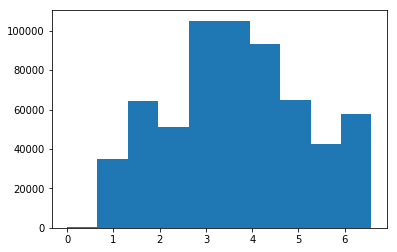

In [47]:
plt.hist(np.log(winsorize(training.event_count, limits=[0,0.05])))

In [45]:
training[training.event_count>10000]['user_purchase_binary_7_days']

5854      False
6871      False
25437      True
27646      True
44965     False
45866      True
93535     False
120760    False
124204     True
127955    False
172748     True
181179    False
191010    False
208431     True
229245    False
236202    False
241564    False
272527     True
284399     True
285393    False
288370    False
291583    False
315941     True
328567     True
357861     True
358147     True
378806    False
394427     True
419015    False
426870     True
439724    False
457369    False
467930     True
491403    False
502910     True
551192    False
560882    False
563844    False
579486    False
598121     True
600019     True
603035    False
615161    False
Name: user_purchase_binary_7_days, dtype: bool

### Categorical Feature Encoding
There are two categorical features, Country and OS, since OS only has 3 different values, we will use One-Hot Encoding. However, there are 200+ countries, we will use mean encoding for this feature, to avoid overfitting, we use 5-fold mean encoding to regularize the encoding.

In [40]:
# One-Hot Encoding OS
training['os_name'] = training['os_name'].fillna(value='Missing')
os = pd.get_dummies(training['os_name']).drop(columns = ['Missing'])
os['os_ios'], os['os_android'] = os['iOS']+os['iPhone OS'], os['Android OS']
os = os.loc[:,['os_ios', 'os_android']]
training = pd.concat((training,os), axis=1)

In [41]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap,session_gap,life_time,os_ios,os_android
0,10c0a284329d5994f988df7c8ce1fcae29b5da5ae796a2...,False,False,9,0,3,TH,Android OS,1.062340e+05,0.0,2.922449e+09,3.000476e+09,4.208975e+09,0,1
1,7feb59e779968e3f7f55ba15b73f9705803509735f0c74...,False,False,83,0,3,US,iOS,1.230632e+06,0.0,2.135871e+09,2.826139e+09,2.849880e+09,1,0
2,3e85e69d36f20a5c3d7d8b7a4966d2e93520106482f48f...,False,False,16,0,1,US,iOS,0.000000e+00,0.0,3.696119e+09,3.861932e+09,3.861932e+09,1,0
3,df4e1fdfd8b28c6e01acdb1bd494e5e8500b75d16d2904...,False,False,72,0,1,US,Android OS,0.000000e+00,0.0,4.382698e+09,4.502634e+09,4.502634e+09,0,1
4,923f5178fe8862386063a31334eab13edee2be24565bd3...,False,False,103,0,2,LK,Android OS,1.510867e+06,0.0,5.058368e+07,5.251371e+07,2.003932e+09,0,1


In [44]:
# Mean Encoding Country
def reg_target_encoding(train, col = "country", splits=5):

    train[f'{col}_mean_enc'] = 0
    train_y2 = training.user_purchase_binary_14_days.values
    skf = StratifiedKFold(splits, shuffle=True, random_state=111)
    
    for computing_index, encoding_index in skf.split(training,train_y2):
        computing, encoding = train.iloc[computing_index], train.iloc[encoding_index]
        means = computing.groupby(col).user_purchase_binary_14_days.mean()
        train.loc[encoding_index,f'{col}_mean_enc'] = encoding[col].map(means)
reg_target_encoding(training)

In [45]:
training.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days,event_count,purchase_count,session_count,country,os_name,mean_sessions_duration,spend,event_gap,session_gap,life_time,os_ios,os_android,country_mean_enc
0,10c0a284329d5994f988df7c8ce1fcae29b5da5ae796a2...,False,False,9,0,3,TH,Android OS,1.062340e+05,0.0,2.922449e+09,3.000476e+09,4.208975e+09,0,1,0.002740
1,7feb59e779968e3f7f55ba15b73f9705803509735f0c74...,False,False,83,0,3,US,iOS,1.230632e+06,0.0,2.135871e+09,2.826139e+09,2.849880e+09,1,0,0.015200
2,3e85e69d36f20a5c3d7d8b7a4966d2e93520106482f48f...,False,False,16,0,1,US,iOS,0.000000e+00,0.0,3.696119e+09,3.861932e+09,3.861932e+09,1,0,0.015266
3,df4e1fdfd8b28c6e01acdb1bd494e5e8500b75d16d2904...,False,False,72,0,1,US,Android OS,0.000000e+00,0.0,4.382698e+09,4.502634e+09,4.502634e+09,0,1,0.015025
4,923f5178fe8862386063a31334eab13edee2be24565bd3...,False,False,103,0,2,LK,Android OS,1.510867e+06,0.0,5.058368e+07,5.251371e+07,2.003932e+09,0,1,0.003191


## Prediction Features

Lets wrap up all feature generating procedures and use it in prediction dataset.

In [46]:
def mean_encoding_test(test, train, col = "country"):

    global_mean = train.user_purchase_binary_14_days.mean()
    mean_device_type = train.groupby(col).user_purchase_binary_14_days.mean()
    test[f'{col}_mean_enc'] = test[col].map(mean_device_type)
    test[f'{col}_mean_enc'].fillna(global_mean, inplace=True)

In [47]:
def feature_generate(df, events_df, session_df):
    
    # Feature one: event_count
    count = events_df.loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'event_count'})
    df = df.join(count.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature two: purchase_count
    count = events_df[events_df.event=='8'].loc[:, ['user_id_hash', 'event']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'event':'purchase_count'})
    df = df.join(count.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature three: session_count
    count = session_df.loc[:, ['user_id_hash', 'session_id']].groupby('user_id_hash').\
    count().reset_index().rename(columns={'session_id':'session_count'})
    df = df.join(count.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature four: country
    country = session_df.loc[:, ['user_id_hash', 'country']].groupby('user_id_hash').\
    first().reset_index()
    df = df.join(country.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature five: OS
    os = session_df.loc[:, ['user_id_hash', 'os_name']].groupby('user_id_hash').\
    first().reset_index()
    df = df.join(os.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature six: session_duration
    duration = session_df.loc[:, ['user_id_hash', 'previous_sessions_duration']].groupby('user_id_hash').\
    mean().reset_index()
    df = df.join(duration.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature seven: spend
    spend = events_df[events_df.event=='8'].loc[:, ['user_id_hash', 'event_value']].groupby('user_id_hash').\
    sum().reset_index().rename(columns={'event_value':'spend'})
    df = df.join(spend.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature eight: event_gap
    event_gap = events_df.loc[:, ['user_id_hash', 'event_timestamp']].groupby('user_id_hash').\
    max().reset_index().rename(columns={'event_timestamp':'event_gap'})
    event_gap['event_gap'] = 1544831999484 - event_gap['event_gap'] 
    df = df.join(event_gap.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature nine: session_gap
    session_gap = session_df.loc[:, ['user_id_hash', 'start_timestamp']].groupby('user_id_hash').\
    max().reset_index().rename(columns={'start_timestamp':'session_gap'})
    session_gap['session_gap'] = 1544831999484 - session_gap['session_gap'] 
    df = df.join(session_gap.set_index('user_id_hash'), on = 'user_id_hash')
    
    # Feature ten: life_time
    life_time = session_df.loc[:, ['user_id_hash', 'user_created_timestamp']].groupby('user_id_hash').\
    max().reset_index().rename(columns={'user_created_timestamp':'life_time'})
    life_time['life_time'] = 1544831999484 - life_time['life_time'] 
    df = df.join(life_time.set_index('user_id_hash'), on = 'user_id_hash')
    
    # One-Hot Encoding OS
    df['os_name'] = df['os_name'].fillna(value='Missing')
    os = pd.get_dummies(df['os_name']).drop(columns = ['Missing'])
    os['os_ios'], os['os_android'] = os['iOS']+os['iPhone OS'], os['Android OS']
    os = os.loc[:,['os_ios', 'os_android']]
    df = pd.concat((df,os), axis=1)
    
    mean_encoding_test(df, training, col = "country")
    return df

In [ ]:
submit = feature_generate(submission, events, session)

In [ ]:
submit.head()

In [ ]:
submission.head()

## Model

In [ ]:
X = training.drop(columns =['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name'])
y = training['user_purchase_binary_7_days']
X_test = submit.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name'])

In [115]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 40,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8,
         'bagging_seed': 11,
         'reg_alpha': 1.7,
         'reg_lambda': 5,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.8,
#          'min_gain_to_split': 0.01,
#          'min_child_weight': 20,
         'num_threads': 4}

In [ ]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [122]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                      valid_sets = [train_data, valid_data], 
                      verbose_eval=300, 
                      early_stopping_rounds = 200)
            
    #y_pred_valid = model.predict(X_valid)
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/n_fold

Fold 0 started at Mon Feb 18 04:12:04 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.974345	valid_1's auc: 0.971998
[600]	training's auc: 0.976271	valid_1's auc: 0.973568
[900]	training's auc: 0.977183	valid_1's auc: 0.97389
[1200]	training's auc: 0.978002	valid_1's auc: 0.974197
[1500]	training's auc: 0.978594	valid_1's auc: 0.974382
[1800]	training's auc: 0.979117	valid_1's auc: 0.974516
[2100]	training's auc: 0.979524	valid_1's auc: 0.974564
[2400]	training's auc: 0.979943	valid_1's auc: 0.974607
Early stopping, best iteration is:
[2344]	training's auc: 0.979854	valid_1's auc: 0.97465
Fold 1 started at Mon Feb 18 04:14:35 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.974003	valid_1's auc: 0.974068
[600]	training's auc: 0.975958	valid_1's auc: 0.975329
[900]	training's auc: 0.976866	valid_1's auc: 0.975858
[1200]	training's auc: 0.977602	valid_1's auc: 0.976209
[1500]	training's auc: 0.978206	v

In [123]:
prediction1 = prediction

In [124]:
X = training.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name'])
y = training['user_purchase_binary_14_days']
X_test = submit.drop(columns = ['user_id_hash', 'user_purchase_binary_7_days', 'user_purchase_binary_14_days','country','os_name'])

In [125]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                      valid_sets = [train_data, valid_data], 
                      verbose_eval=300, 
                      early_stopping_rounds = 200)
            
    #y_pred_valid = model.predict(X_valid)
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/n_fold

Fold 0 started at Mon Feb 18 04:29:47 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.96631	valid_1's auc: 0.966227
[600]	training's auc: 0.968921	valid_1's auc: 0.968973
[900]	training's auc: 0.970179	valid_1's auc: 0.969958
[1200]	training's auc: 0.971046	valid_1's auc: 0.970435
[1500]	training's auc: 0.971721	valid_1's auc: 0.970649
[1800]	training's auc: 0.97231	valid_1's auc: 0.970908
[2100]	training's auc: 0.972819	valid_1's auc: 0.97108
[2400]	training's auc: 0.973244	valid_1's auc: 0.971206
[2700]	training's auc: 0.973706	valid_1's auc: 0.971311
[3000]	training's auc: 0.974085	valid_1's auc: 0.97137
[3300]	training's auc: 0.974434	valid_1's auc: 0.971406
Early stopping, best iteration is:
[3356]	training's auc: 0.974487	valid_1's auc: 0.971423
Fold 1 started at Mon Feb 18 04:33:24 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.966575	valid_1's auc: 0.965094
[600]	training's auc: 0.969154	va

In [126]:
prediction2 = prediction

In [127]:
submission['user_purchase_binary_7_days'] = prediction1
submission['user_purchase_binary_14_days'] = prediction2

In [128]:
submission.to_csv('submission0217.csv', index=False)

In [129]:
!kaggle competitions submit predict-in-app-purchase -f submission0217.csv -m "Using full 11 features and model on lgbm"

100%|██████████████████████████████████████| 32.6M/32.6M [00:02<00:00, 16.1MB/s]
Successfully submitted to Predict in-app purchases